# Install Necessary Module

In [1]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.4 MB/s eta 0:00:00


# 1. Import Statements

In [2]:
# Standard Libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress all warnings
warnings.filterwarnings("ignore")

# Machine Learning Libraries
# Data Preprocessing and Transformation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
)
from pandas.plotting import parallel_coordinates
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning Models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

# Metrics and Evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, roc_auc_score, precision_score, roc_curve, auc 
)

# Deep Learning Libraries
# TensorFlow and Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold

# Natural Language Processing Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, KeyedVectors
from tensorflow.keras.models import load_model

# Transformers (Hugging Face)
from transformers import BertTokenizer, BertForSequenceClassification

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Explainability Libraries
import shap
import lime

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 2. Dataset Loading

In [3]:
df = pd.read_csv("/kaggle/input/disease-prediction/Training.csv")

# Inspecting the dataset
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (4920, 133)


,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


# 3. Data Preprocessing

# 3.1 Text Data Preprocessing

In [4]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Function to preprocess text data (tokenization, stop-word removal, and stemming)
def preprocess_text(text):
    # Tokenize text into words
    tokens = nltk.word_tokenize(text.lower())
    
    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming (using Porter Stemmer)
    stemmer = nltk.PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    return " ".join(tokens)

# Apply text preprocessing to the 'prognosis' column
df['processed_prognosis'] = df['prognosis'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 3.2 Structured Data Preprocessing

In [5]:
# Identify columns with missing values
missing_values = df.isnull().sum()

# Set up imputation strategies for numerical and categorical data
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Imputation for missing numerical data (replace with median)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Imputation for missing categorical data (replace with most frequent)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer that applies the respective transformation
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Apply the preprocessing steps to the dataset
df_processed = preprocessor.fit_transform(df)

# Convert the transformed data back into a DataFrame (optional)
df_processed = pd.DataFrame(df_processed)

df_processed.head()

,0,1,2,3,4,5,6,7,8,9,...,203,204,205,206,207,208,209,210,211,212
0,2.501327,2.293369,6.674995,-0.21738,-0.149813,-0.439995,-0.401837,-0.21738,-0.21738,-0.149813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.399788,2.293369,6.674995,-0.21738,-0.149813,-0.439995,-0.401837,-0.21738,-0.21738,-0.149813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.501327,-0.436040,6.674995,-0.21738,-0.149813,-0.439995,-0.401837,-0.21738,-0.21738,-0.149813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.501327,2.293369,-0.149813,-0.21738,-0.149813,-0.439995,-0.401837,-0.21738,-0.21738,-0.149813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.501327,2.293369,6.674995,-0.21738,-0.149813,-0.439995,-0.401837,-0.21738,-0.21738,-0.149813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3.3 Word Embedding Generation (Word2Vec)

In [6]:
# Step 1: Define the Word2Vec model and train it on the processed prognosis data
# Tokenizing the 'processed_prognosis' column into sentences (lists of words)
sentences = [text.split() for text in df['processed_prognosis']]  # Tokenize into words

word2vec_model = Word2Vec(
    sentences, 
    vector_size=100, 
    window=5, 
    min_count=1, 
    workers=4
)

# Step 3: Save the trained Word2Vec model (optional, for reuse in future tasks)
word2vec_model.save("prognosis_word2vec.model")

# Step 4: Extract the trained word vectors for further analysis
word_vectors = word2vec_model.wv

# Display the tokenized sentences for better understanding
print("\n--- Tokenized Sentences (Preview) ---")
for i, sentence in enumerate(sentences[:5]):  # Show only the first 5 sentences for brevity
    print(f"Sentence {i + 1}: {sentence}")


--- Tokenized Sentences (Preview) ---
Sentence 1: ['fungal', 'infect']
Sentence 2: ['fungal', 'infect']
Sentence 3: ['fungal', 'infect']
Sentence 4: ['fungal', 'infect']
Sentence 5: ['fungal', 'infect']


# 3.4 Text Vectorization (TF-IDF)

In [7]:
# Step 1: Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Step 2: Apply the TF-IDF transformation
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_prognosis'])

# Step 3: Convert the sparse matrix to a dense array
X_tfidf = X_tfidf.toarray()

# Step 4: Display the results for better understanding
print("\n--- TF-IDF Transformation Summary ---")
print(f"Shape of TF-IDF Matrix: {X_tfidf.shape} (Samples, Features)")
print(f"Example Feature Names: {tfidf_vectorizer.get_feature_names_out()[:10]}")


--- TF-IDF Transformation Summary ---
Shape of TF-IDF Matrix: (4920, 55) (Samples, Features)
Example Feature Names: ['acn' 'aid' 'alcohol' 'allergi' 'arthriti' 'asthma' 'attack' 'brain'
 'bronchial' 'cervic']


# 4. Exploratory Data Analysis Visualization

In [8]:
df['prognosis_encoded'] = LabelEncoder().fit_transform(df['prognosis'])

# EDA
feature_correlation = df.corr(numeric_only=True)['prognosis_encoded'].sort_values(ascending=False)
top_15_features = feature_correlation.index[1:16]
selected_features_df = df[top_15_features.tolist() + ['prognosis_encoded']]

# 4.1 Distribution Histograms

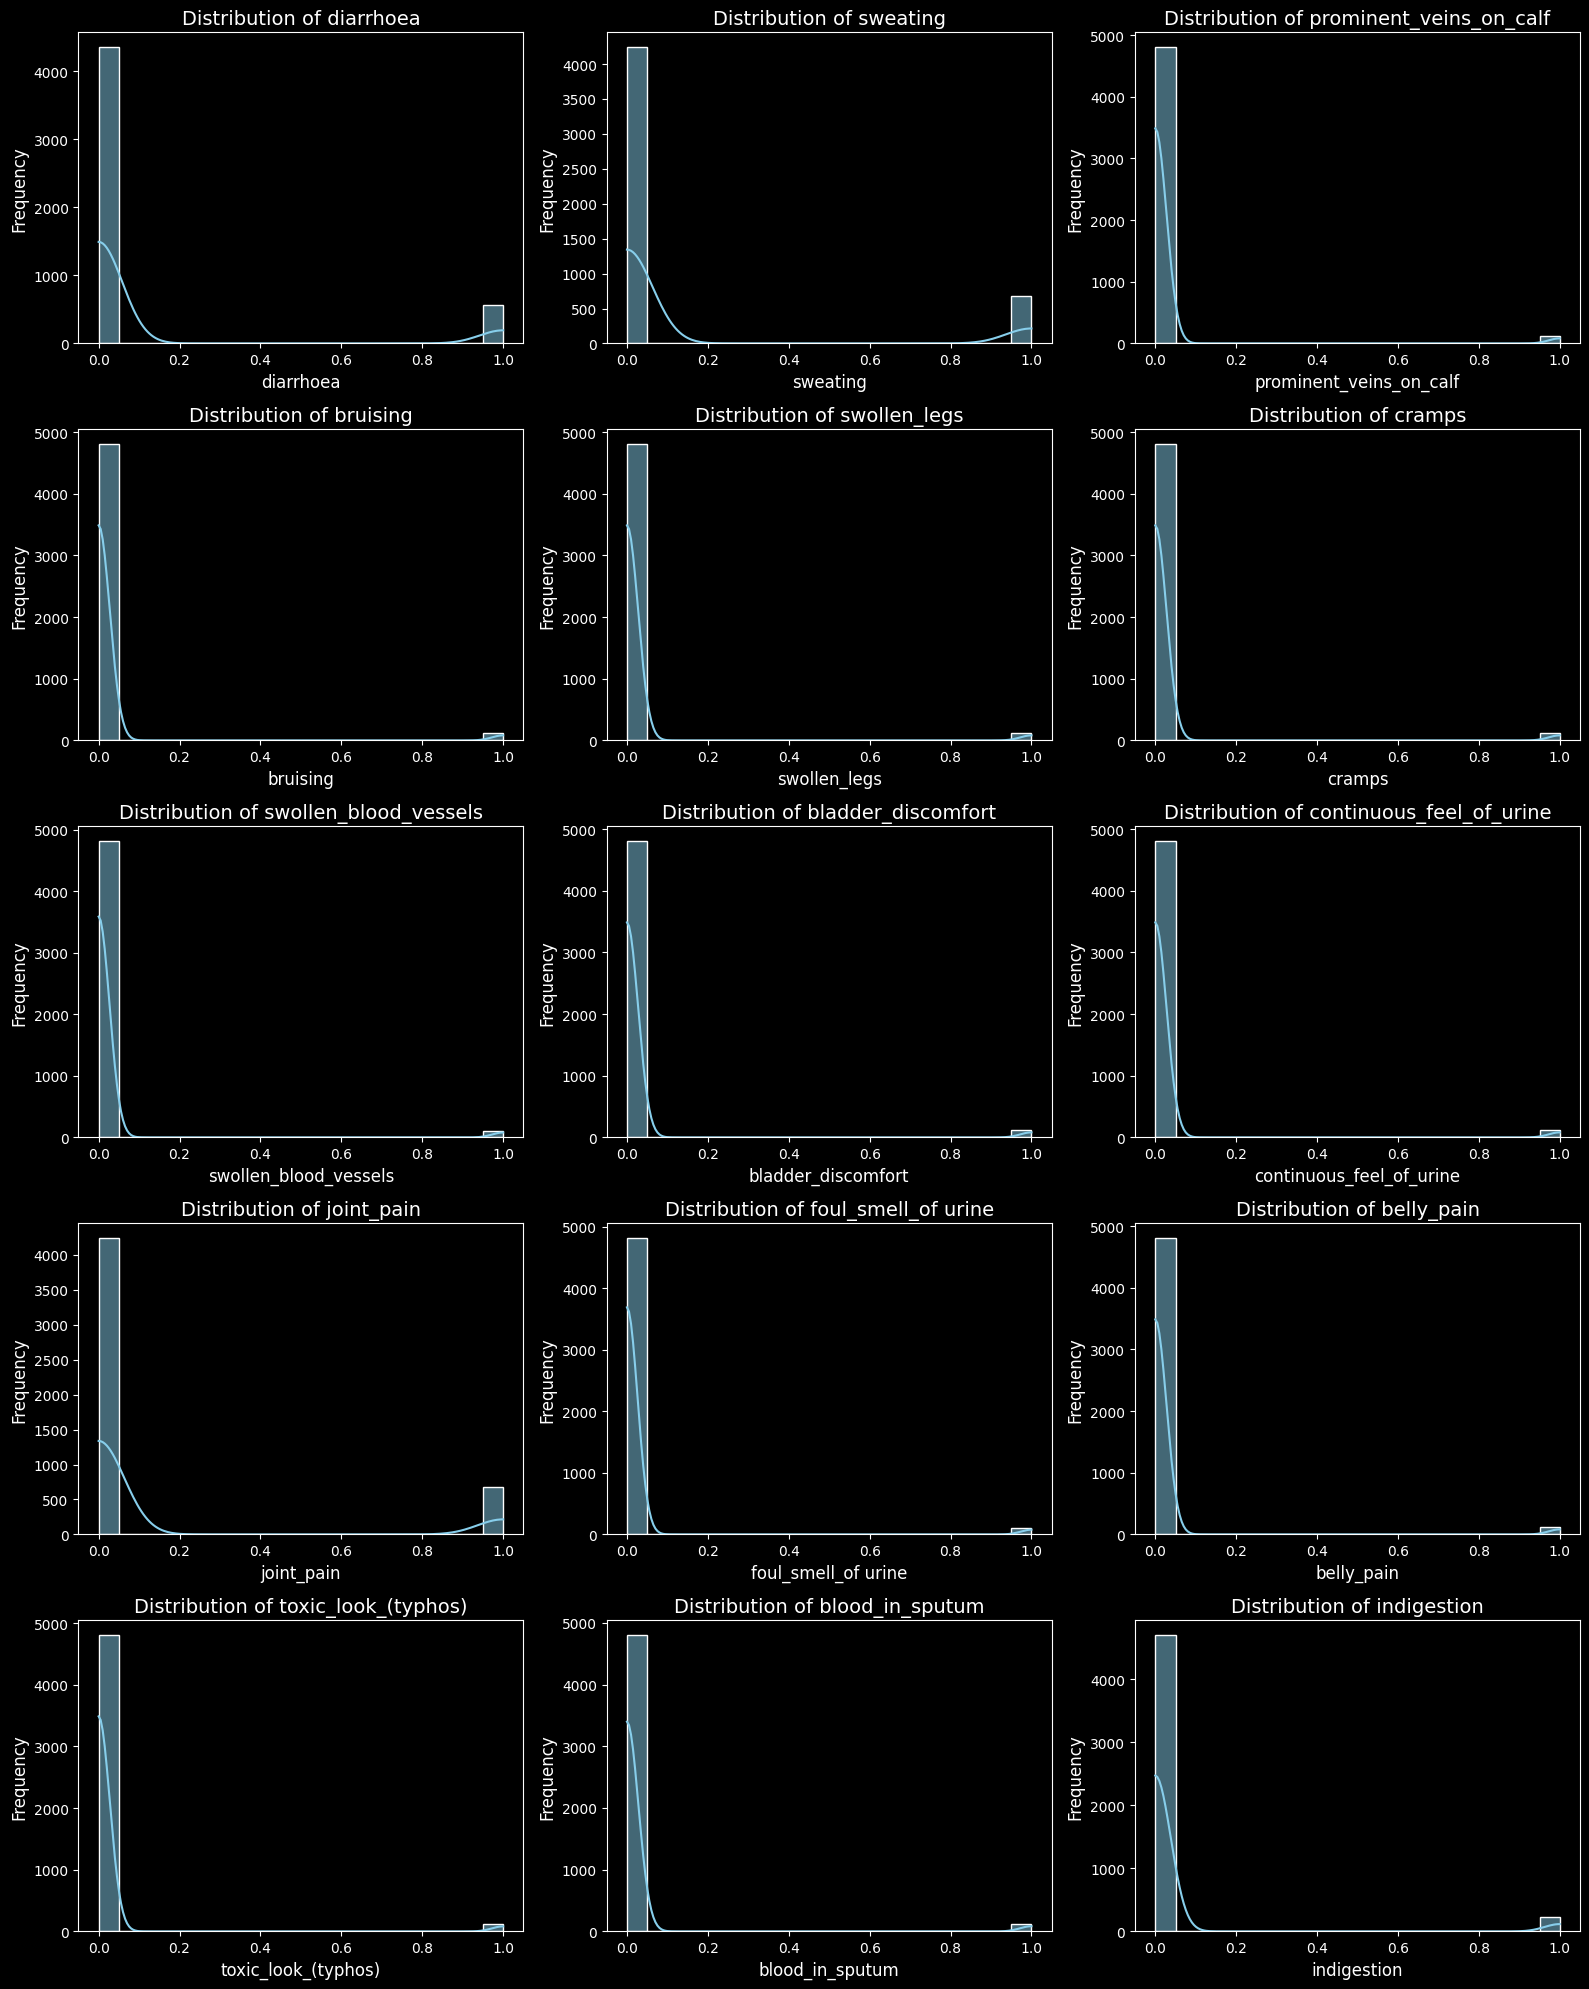

In [9]:
plt.style.use('dark_background')

plt.figure(figsize=(16, 20))
for i, feature in enumerate(top_15_features, 1):
    plt.subplot(5, 3, i)
    sns.histplot(selected_features_df[feature], kde=True, color="skyblue", bins=20)
    plt.title(f"Distribution of {feature}", fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# 4.2 Correlatipn HeatMap

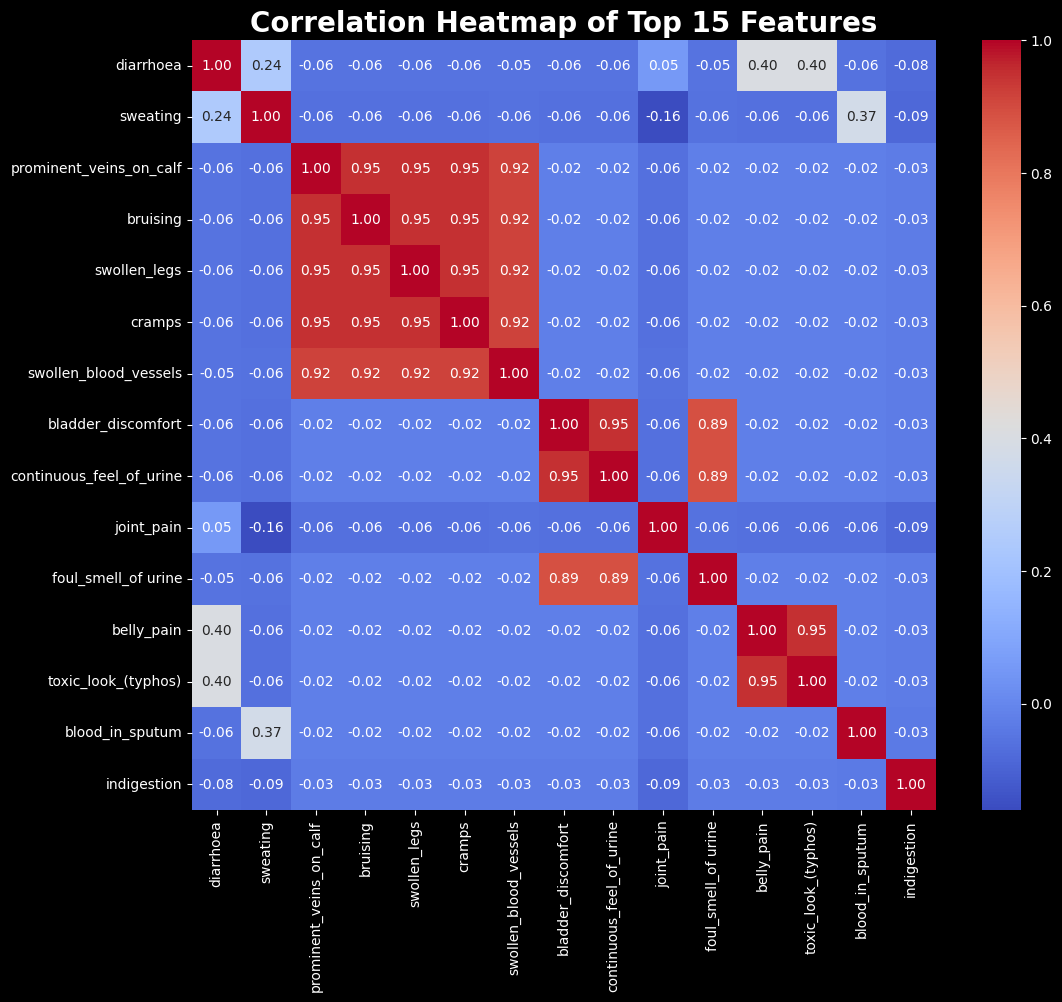

In [10]:
plt.figure(figsize=(12, 10))
sns.heatmap(selected_features_df[top_15_features].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Top 15 Features", fontsize=20, weight="bold")
plt.show()

# 4.3 Top Correlated Features Bar Plot

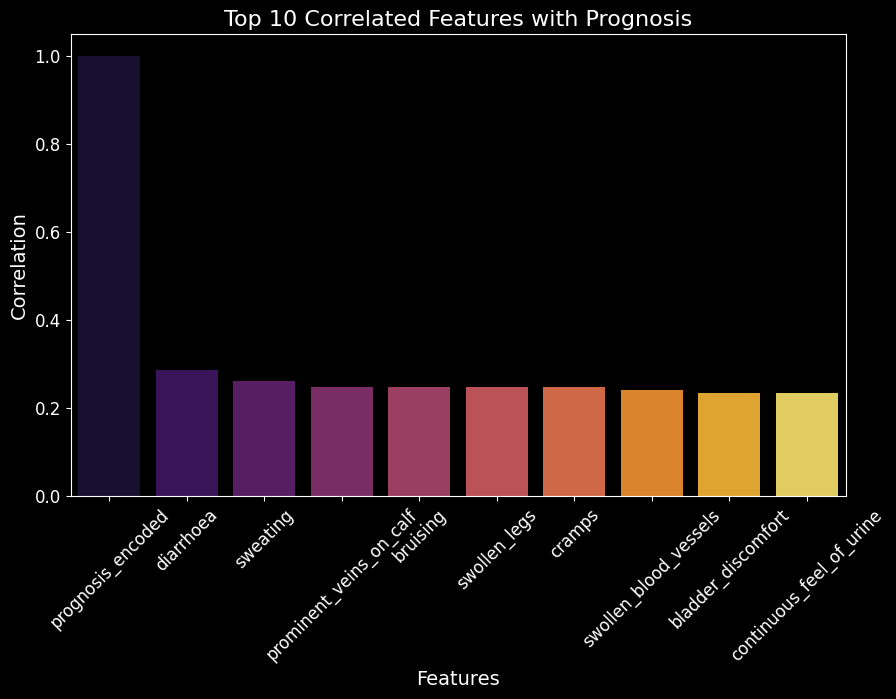

In [11]:
label_encoder = LabelEncoder()
df['prognosis_encoded'] = label_encoder.fit_transform(df['prognosis'])

# Recompute the correlation matrix with the encoded prognosis column
correlation = df.corr(numeric_only=True)
top_corr = correlation['prognosis_encoded'].sort_values(ascending=False)

# Visualize the top correlated features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.index[:10], y=top_corr.values[:10], palette='inferno')
plt.title('Top 10 Correlated Features with Prognosis', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 4.4 Prognosis Pairplot

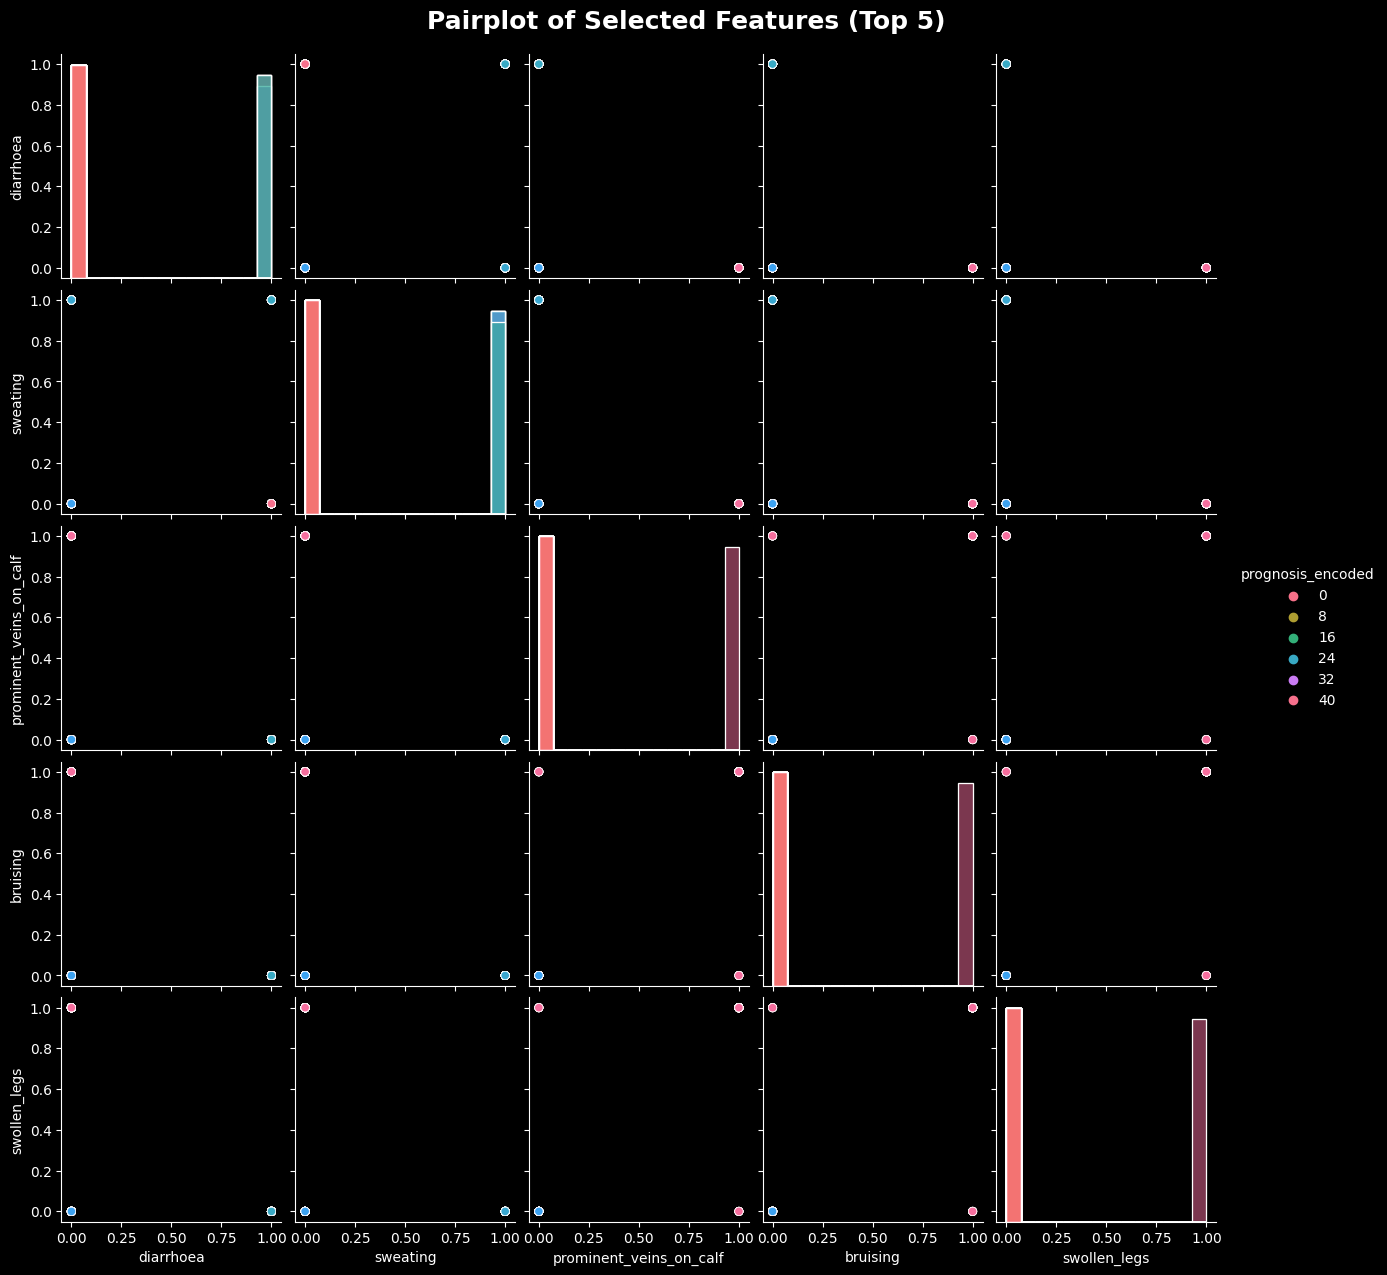

In [12]:
# Ensure 'top_15_features' contains valid column names
valid_features = [feature for feature in top_15_features if feature in selected_features_df.columns]

# Use only valid features for pairplot
pairplot_features = valid_features[:5]  # Limit to the first 5 features for clarity

# Generate the pairplot
sns.pairplot(selected_features_df[pairplot_features + ['prognosis_encoded']], 
             hue='prognosis_encoded', palette='husl', diag_kind='hist', height=2.5)
plt.suptitle('Pairplot of Selected Features (Top 5)', fontsize=18, weight='bold', y=1.02)
plt.show()

# 4.5 KDE Plot for Numerical Features

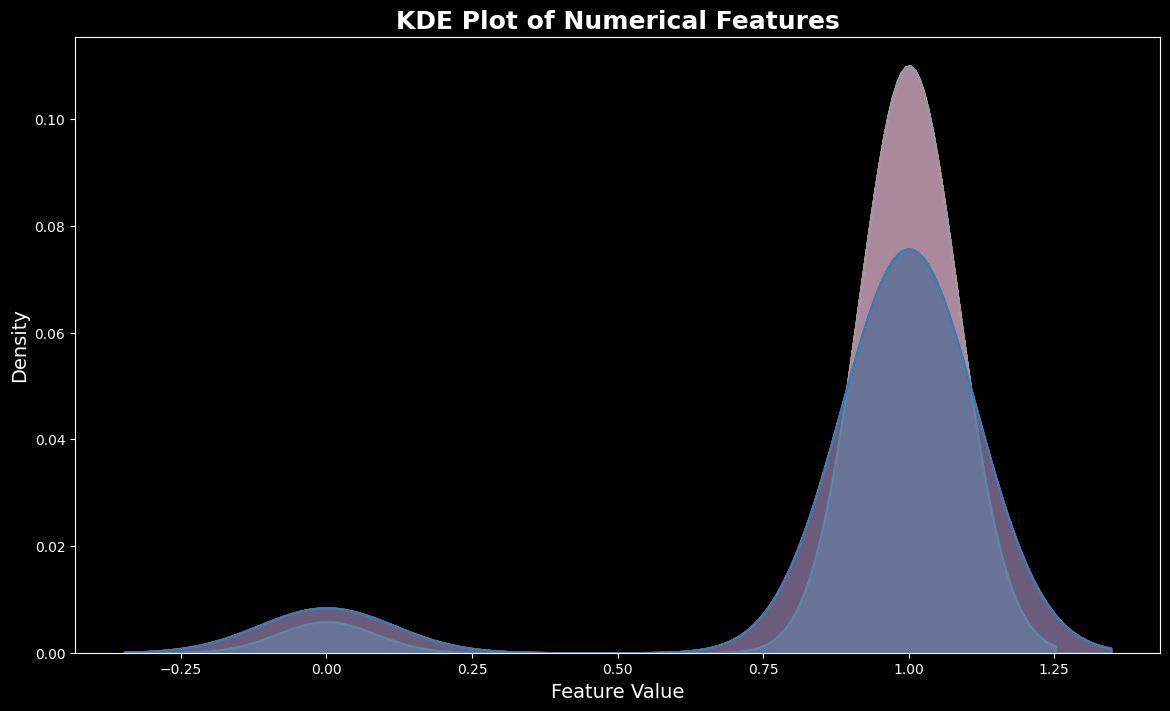

In [ ]:
# KDE Plot for Numerical Features Without Legends
numerical_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(14, 8))
for feature in numerical_cols[:5]:  # First 5 features
    sns.kdeplot(
        data=df, 
        x=feature, 
        hue="prognosis", 
        fill=True, 
        alpha=0.4, 
        linewidth=1.5, 
        palette="Set1"

# Remove legends
plt.title("KDE Plot of Numerical Features", fontsize=18, weight="bold")
plt.xlabel("Feature Value", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.show()

# 4.6 Parallel Coordinates Plot

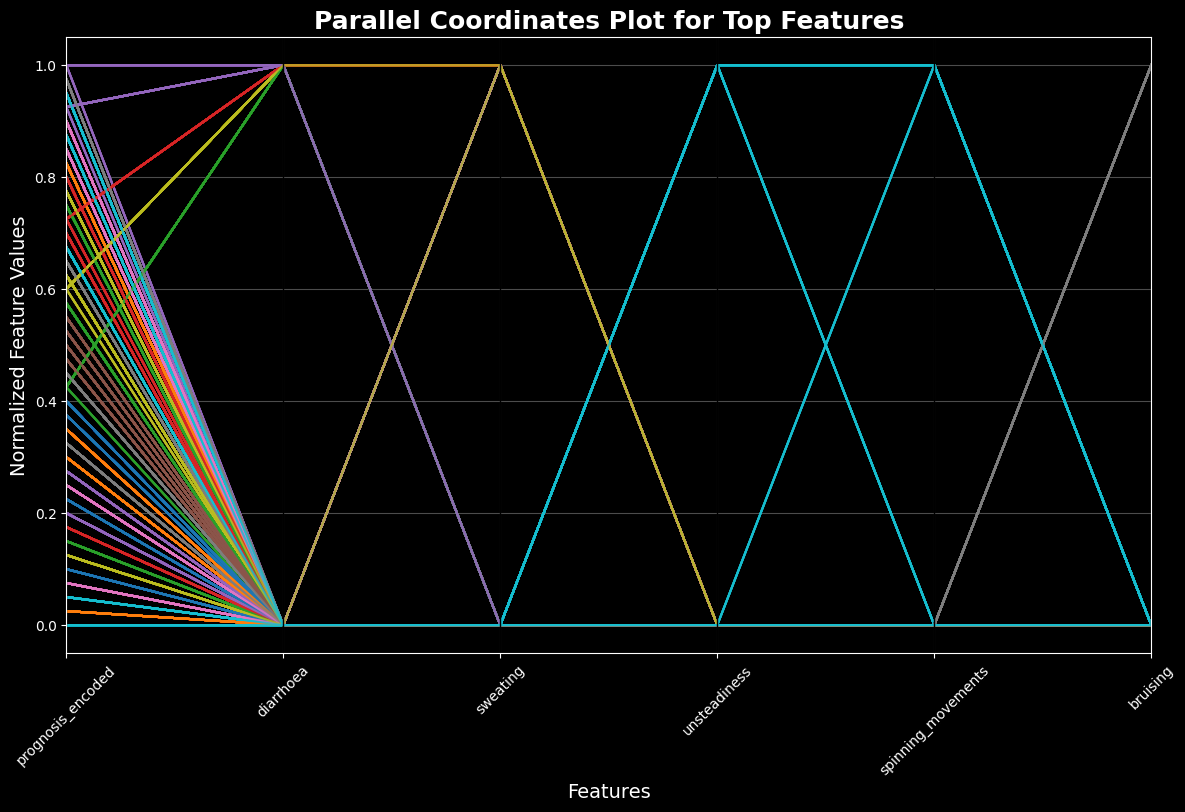

In [14]:
# Select top features based on correlation with 'prognosis_encoded'
top_features = correlation['prognosis_encoded'].abs().sort_values(ascending=False).index[:6]

# Ensure top_features exist in DataFrame by filtering the valid columns
top_features = [col for col in top_features if col in df.columns]

# Normalize the selected features for visualization
scaled_df = df.copy()
scaler = MinMaxScaler()
scaled_df[top_features] = scaler.fit_transform(df[top_features])

# Add 'prognosis' column to scaled_df if not present
if 'prognosis' not in scaled_df.columns:
    scaled_df['prognosis'] = df['prognosis']

# Create parallel coordinates plot
plt.figure(figsize=(14, 8))
parallel_coordinates(
    scaled_df[top_features + ['prognosis']],  # Ensure valid columns are used
    'prognosis',
    colormap=plt.get_cmap("tab10"),
    linewidth=1.5,
    alpha=0.7
)

plt.title("Parallel Coordinates Plot for Top Features", fontsize=18, weight="bold")
plt.ylabel("Normalized Feature Values", fontsize=14)
plt.xlabel("Features", fontsize=14)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# Remove legend
plt.legend([], [], frameon=False)

plt.show()

# 4.7 Voilin Plot

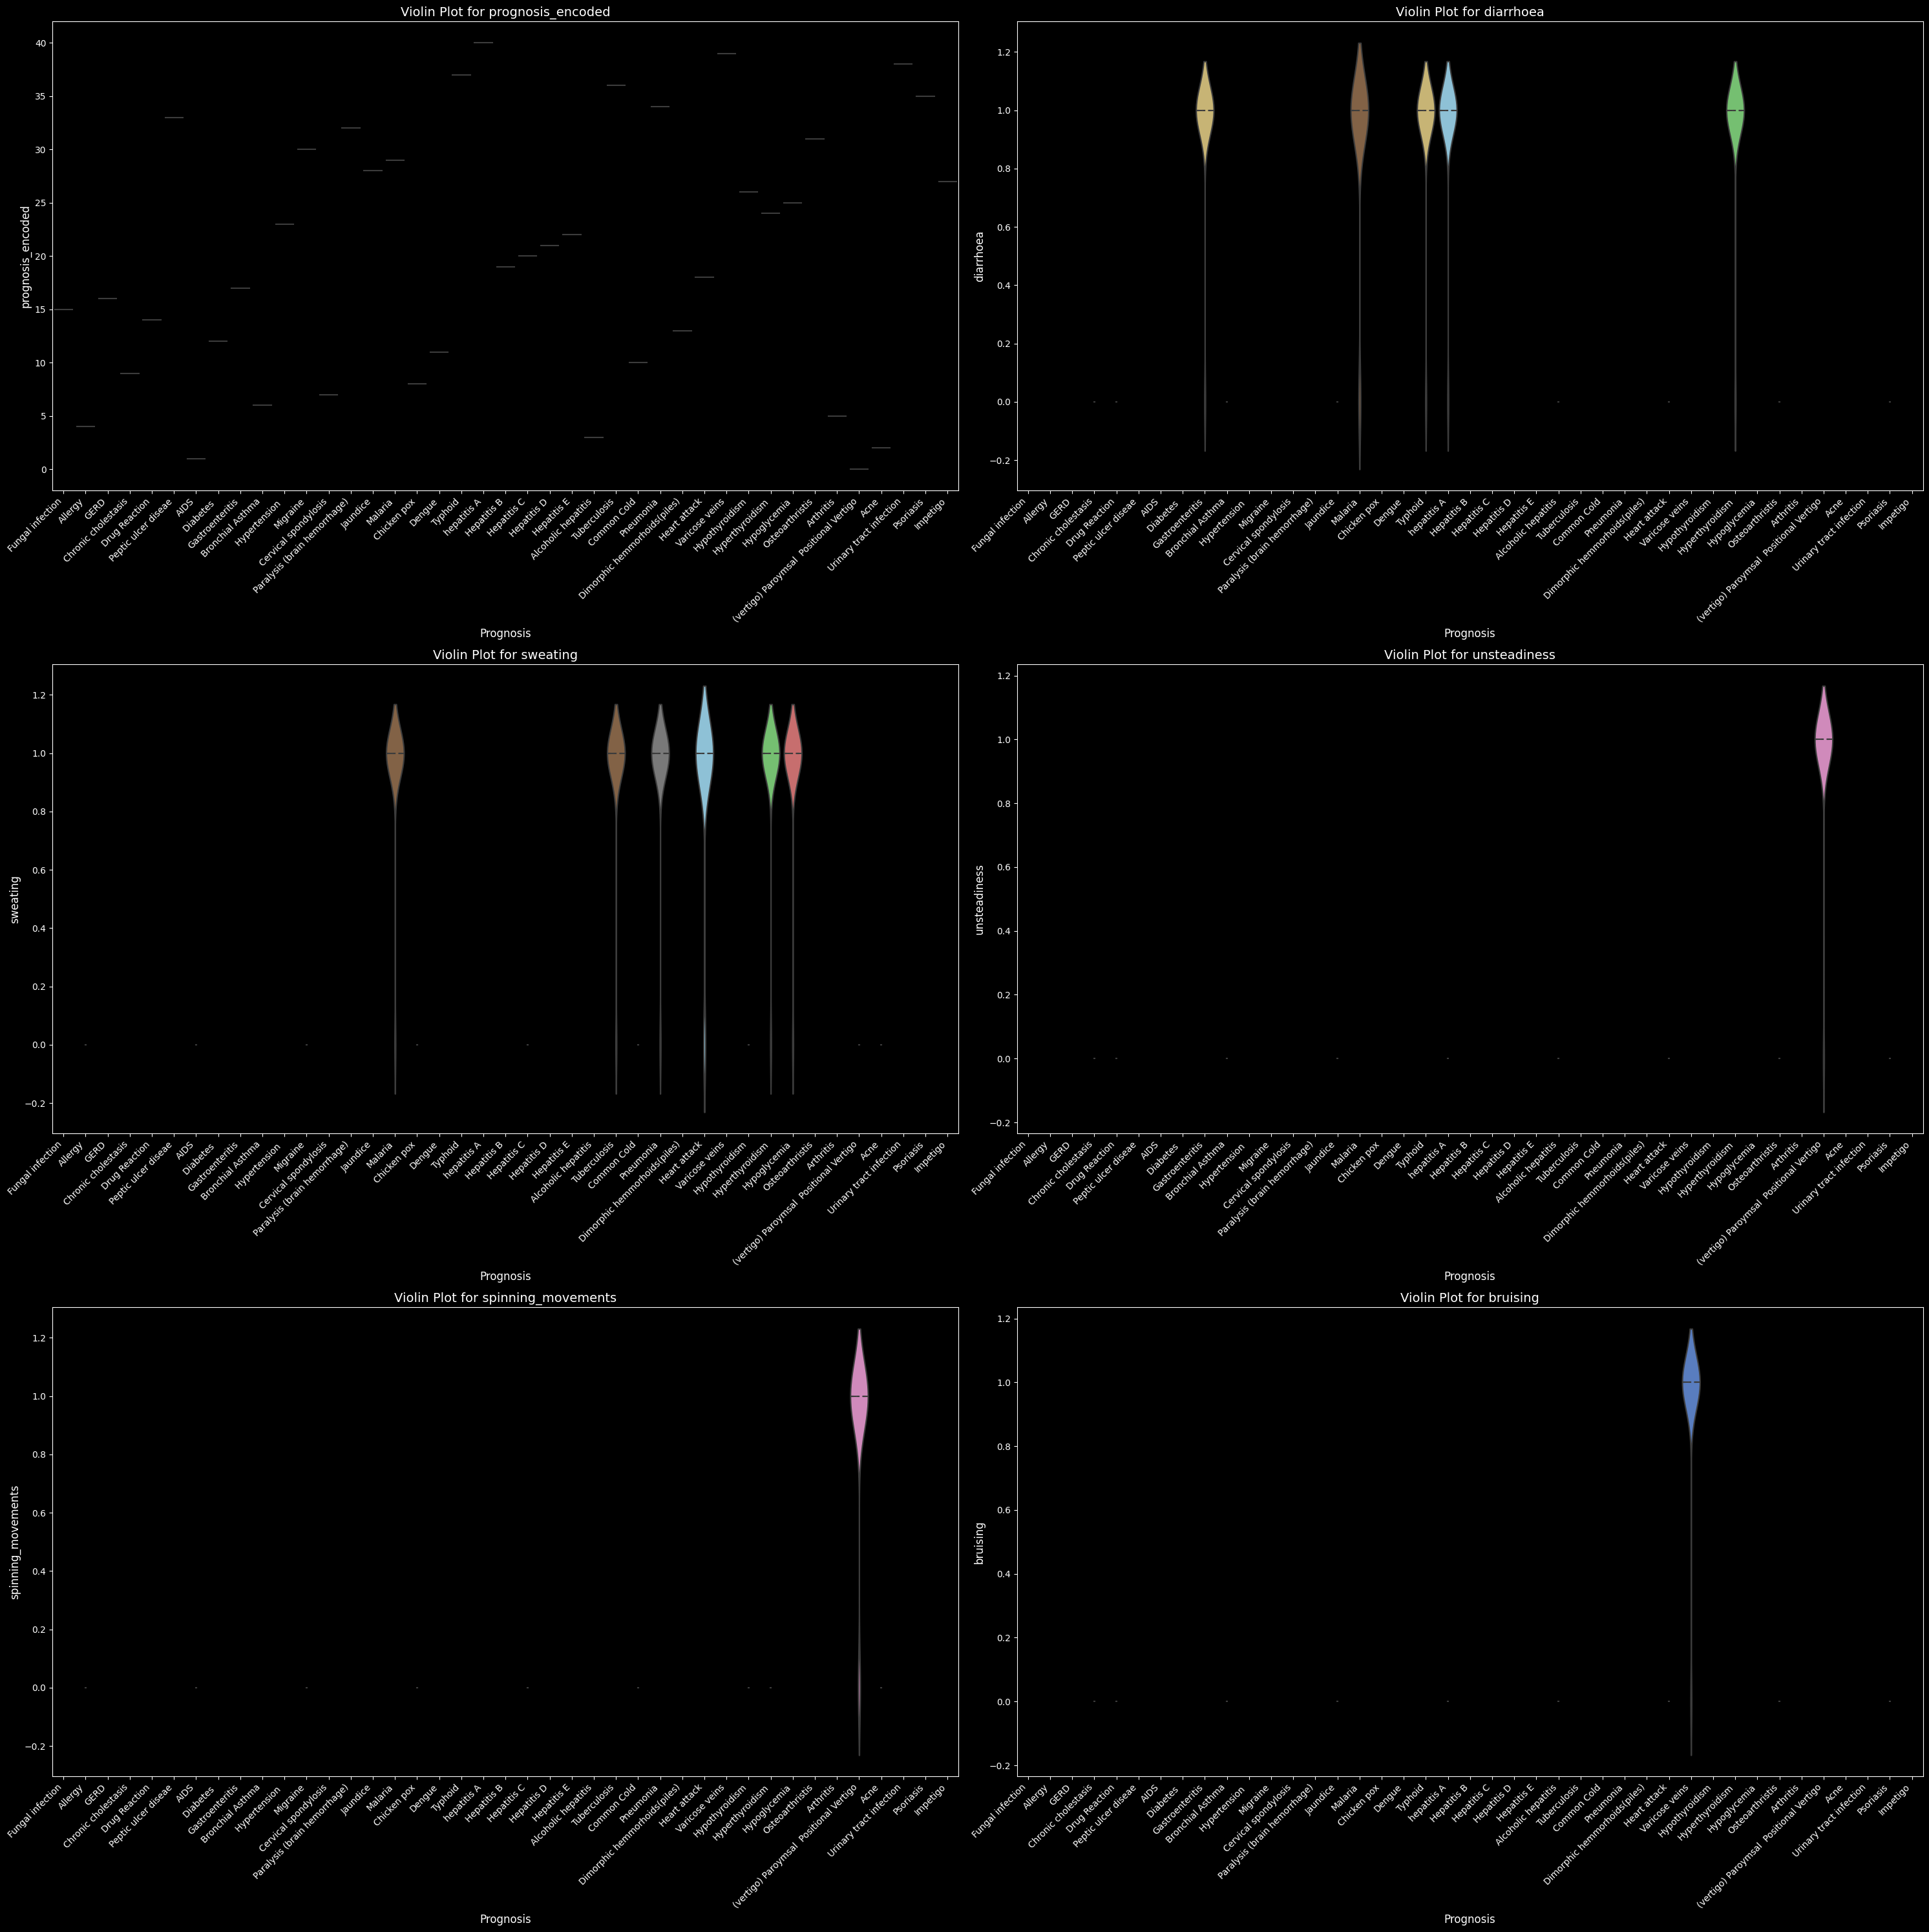

In [15]:
plt.figure(figsize=(30, 30))
for i, feature in enumerate(top_features, 1):
    plt.subplot(3, 2, i)
    sns.violinplot(x='prognosis', y=feature, data=df, palette='muted', scale='count', inner="quartile")
    plt.title(f"Violin Plot for {feature}", fontsize=14)
    plt.xlabel("Prognosis", fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better alignment
plt.tight_layout()
plt.show()

# 4.8 Scatter Plot

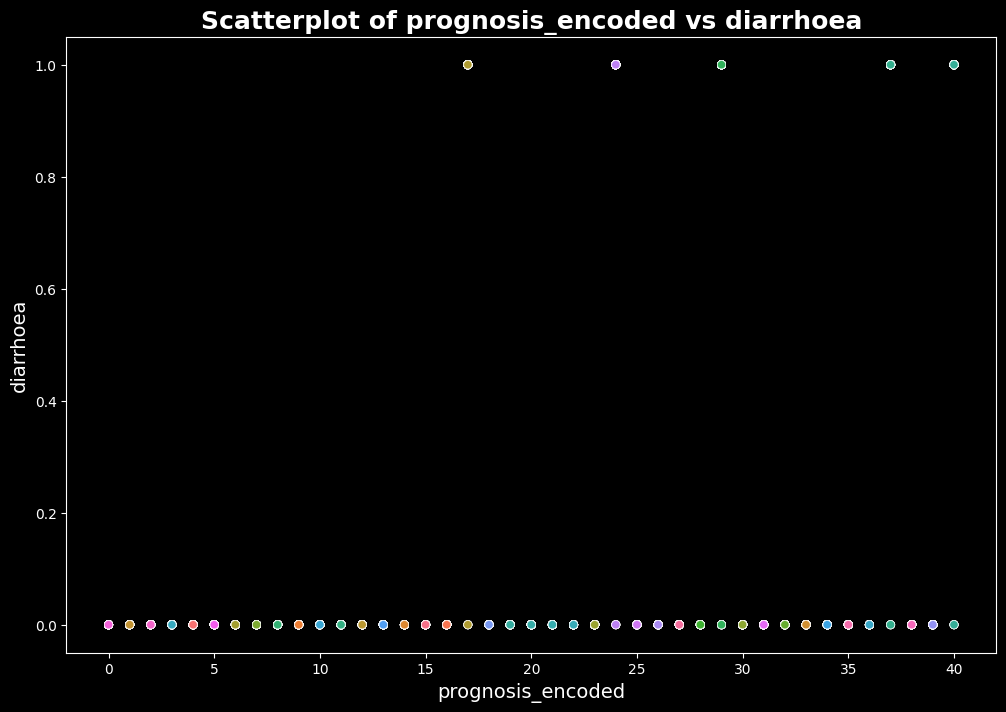

In [16]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=top_features[0], y=top_features[1], hue='prognosis', palette="husl", alpha=0.8, data=df)
plt.title(f"Scatterplot of {top_features[0]} vs {top_features[1]}", fontsize=18, weight="bold")
plt.xlabel(top_features[0], fontsize=14)
plt.ylabel(top_features[1], fontsize=14)
plt.legend([], [], frameon=False)
plt.show()

# 5. Data Splitting

In [17]:
# Step 1: Define features (X) and target (y)
# Use the fully preprocessed DataFrame (df_processed) as features
X = df_processed
y = df['prognosis_encoded']

# Step 2: Split the data into training, validation, and test sets
# 60% training, 20% validation, 20% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Split the remaining 40% into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Display the shapes of the splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (2952, 213) (2952,)
Validation set shape: (984, 213) (984,)
Test set shape: (984, 213) (984,)


# 6. Model Development

# 6.1 Catboost Model Training

In [18]:
# Initialize CatBoost
cat_clf = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=10, loss_function='MultiClass', verbose=100)

# Train
cat_clf.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

# Predict
y_pred = cat_clf.predict(X_test)
print(classification_report(y_test, y_pred))

0:	learn: 3.4699542	test: 3.4667779	best: 3.4667779 (0)	total: 199ms	remaining: 3m 18s
100:	learn: 0.1443384	test: 0.1485988	best: 0.1485988 (100)	total: 11.3s	remaining: 1m 40s
200:	learn: 0.0321888	test: 0.0336777	best: 0.0336777 (200)	total: 22.9s	remaining: 1m 30s
300:	learn: 0.0143481	test: 0.0151625	best: 0.0151625 (300)	total: 33.9s	remaining: 1m 18s
400:	learn: 0.0092573	test: 0.0098987	best: 0.0098987 (400)	total: 45s	remaining: 1m 7s
500:	learn: 0.0069520	test: 0.0074945	best: 0.0074945 (500)	total: 56.5s	remaining: 56.3s
600:	learn: 0.0055551	test: 0.0060313	best: 0.0060313 (600)	total: 1m 7s	remaining: 44.8s
700:	learn: 0.0046258	test: 0.0050540	best: 0.0050540 (700)	total: 1m 18s	remaining: 33.5s
800:	learn: 0.0040010	test: 0.0043914	best: 0.0043914 (800)	total: 1m 30s	remaining: 22.4s
900:	learn: 0.0035246	test: 0.0038865	best: 0.0038865 (900)	total: 1m 41s	remaining: 11.1s
999:	learn: 0.0031466	test: 0.0034824	best: 0.0034824 (999)	total: 1m 52s	remaining: 0us

bestTest 

# 6.2 XGBoost Model Training

In [19]:
# Initialize XGBoost
xgb_clf = XGBClassifier(objective='multi:softmax', num_class=len(set(y_train)), eval_metric='mlogloss')

# Train
xgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=True)

# Predict
y_pred = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred))

[0]	validation_0-mlogloss:0.25769
[1]	validation_0-mlogloss:0.19117
[2]	validation_0-mlogloss:0.14260
[3]	validation_0-mlogloss:0.10692
[4]	validation_0-mlogloss:0.08061
[5]	validation_0-mlogloss:0.06115
[6]	validation_0-mlogloss:0.04673
[7]	validation_0-mlogloss:0.03601
[8]	validation_0-mlogloss:0.02803
[9]	validation_0-mlogloss:0.02206
[10]	validation_0-mlogloss:0.01757
[11]	validation_0-mlogloss:0.01419
[12]	validation_0-mlogloss:0.01161
[13]	validation_0-mlogloss:0.00963
[14]	validation_0-mlogloss:0.00809
[15]	validation_0-mlogloss:0.00689
[16]	validation_0-mlogloss:0.00689
[17]	validation_0-mlogloss:0.00689
[18]	validation_0-mlogloss:0.00689
[19]	validation_0-mlogloss:0.00689
[20]	validation_0-mlogloss:0.00689
[21]	validation_0-mlogloss:0.00689
[22]	validation_0-mlogloss:0.00689
[23]	validation_0-mlogloss:0.00689
[24]	validation_0-mlogloss:0.00689
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00   

# 6.3 TabNet Model Training

In [20]:
import torch

# Convert DataFrame to NumPy arrays (required for TabNet)
X_train_np = X_train.values
X_val_np = X_val.values
X_test_np = X_test.values
y_train_np = y_train.values
y_val_np = y_val.values
y_test_np = y_test.values

# Initialize TabNetClassifier
tabnet_clf = TabNetClassifier(
    n_d=64,  # Feature transformer dimension
    n_a=64,  # Attention transformer dimension
    n_steps=5,  # Number of decision steps
    gamma=1.5,  # Relaxation factor
    lambda_sparse=0.001,  # Sparsity regularization
    optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    seed=42,
    verbose=1
)

# Train TabNet on the training data
tabnet_clf.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=['validation'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,  # Early stopping patience
    batch_size=256,
    virtual_batch_size=128
)

# Predictions
y_pred = tabnet_clf.predict(X_test_np)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred))
print("Accuracy:", accuracy_score(y_test_np, y_pred))
print("F1 Score:", f1_score(y_test_np, y_pred, average="weighted"))

epoch 0  | loss: 4.38698 | validation_accuracy: 0.23984 |  0:00:01s
epoch 1  | loss: 2.62826 | validation_accuracy: 0.4939  |  0:00:01s
epoch 2  | loss: 1.77109 | validation_accuracy: 0.60264 |  0:00:02s
epoch 3  | loss: 1.34798 | validation_accuracy: 0.63008 |  0:00:02s
epoch 4  | loss: 0.48091 | validation_accuracy: 0.78557 |  0:00:03s
epoch 5  | loss: 0.23324 | validation_accuracy: 0.89939 |  0:00:03s
epoch 6  | loss: 0.10116 | validation_accuracy: 0.89736 |  0:00:04s
epoch 7  | loss: 0.06104 | validation_accuracy: 0.91362 |  0:00:04s
epoch 8  | loss: 0.03727 | validation_accuracy: 0.92175 |  0:00:05s
epoch 9  | loss: 0.0231  | validation_accuracy: 0.89431 |  0:00:05s
epoch 10 | loss: 0.0186  | validation_accuracy: 0.87398 |  0:00:06s
epoch 11 | loss: 0.01511 | validation_accuracy: 0.91463 |  0:00:06s
epoch 12 | loss: 0.02319 | validation_accuracy: 0.96443 |  0:00:07s
epoch 13 | loss: 0.01457 | validation_accuracy: 0.96951 |  0:00:07s
epoch 14 | loss: 0.01416 | validation_accuracy: 

# Data Split for LSTM

In [21]:
# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape X for LSTM: (samples, timesteps, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split data for LSTM
X_train, X_temp, y_train, y_temp = train_test_split(X_lstm, y_categorical, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train Shape:", X_train.shape, y_train.shape)
print("Validation Shape:", X_val.shape, y_val.shape)
print("Test Shape:", X_test.shape, y_test.shape)

Train Shape: (2952, 1, 213) (2952, 41)
Validation Shape: (984, 1, 213) (984, 41)
Test Shape: (984, 1, 213) (984, 41)


# 6.4 LSTM Model Training

In [22]:
# Define LSTM model
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=2
)

Epoch 1/10
93/93 - 4s - 47ms/step - accuracy: 0.4953 - loss: 3.1266 - val_accuracy: 0.9665 - val_loss: 1.4019
Epoch 2/10
93/93 - 1s - 6ms/step - accuracy: 0.9844 - loss: 0.4127 - val_accuracy: 1.0000 - val_loss: 0.0267
Epoch 3/10
93/93 - 1s - 6ms/step - accuracy: 1.0000 - loss: 0.0366 - val_accuracy: 1.0000 - val_loss: 0.0074
Epoch 4/10
93/93 - 1s - 6ms/step - accuracy: 1.0000 - loss: 0.0164 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 5/10
93/93 - 1s - 6ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 6/10
93/93 - 1s - 6ms/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 7/10
93/93 - 1s - 6ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 8.9078e-04
Epoch 8/10
93/93 - 1s - 6ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 6.4748e-04
Epoch 9/10
93/93 - 1s - 6ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 4.8888e-04
Epoch 

In [23]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Convert label_encoder classes to strings
target_names = [str(class_name) for class_name in label_encoder.classes_]

# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=target_names))

31/31 - 0s - 3ms/step - accuracy: 1.0000 - loss: 3.7474e-04
Test Accuracy: 1.0000
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00        24
           9       1.00      1.00      1.00        24
          10       1.00      1.00      1.00        24
          11       1.00      1.00      1.00        24
          12       1.00      1.00      1.00        24
          13       1.00      1.00      1.00        24
          14       1.00      1.00      1.00 

# 6.5 Ensembled Model Training

In [25]:
# Wrapper for LSTM to make it compatible with VotingClassifier
class LSTMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # LSTM model is pre-trained, no fitting needed
        pass

    def predict(self, X):
        reshaped_X = X.reshape((X.shape[0], 1, X.shape[1]))  # Reshape to LSTM input format
        predictions = self.model.predict(reshaped_X)
        return np.argmax(predictions, axis=1)

    def predict_proba(self, X):
        reshaped_X = X.reshape((X.shape[0], 1, X.shape[1]))  # Reshape to LSTM input format
        return self.model.predict(reshaped_X)


# Wrapper for TabNet to make it compatible with VotingClassifier
class TabNetWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, tabnet_model):
        self.tabnet_model = tabnet_model

    def fit(self, X, y):
        self.tabnet_model.fit(X, y)
        return self

    def predict(self, X):
        return self.tabnet_model.predict(X)

    def predict_proba(self, X):
        return self.tabnet_model.predict_proba(X)

# Wrap TabNet and LSTM models
tabnet_clf_wrapper = TabNetWrapper(tabnet_clf)
lstm_clf = LSTMWrapper(model)

# Voting Classifier Ensemble
ensemble_clf = VotingClassifier(
    estimators=[
        ('catboost', cat_clf),
        ('xgboost', xgb_clf),
        ('tabnet', tabnet_clf_wrapper),
        ('lstm', lstm_clf)
    ],
    voting='soft'  # Soft voting combines probabilities
)

In [27]:
# Ensure data is properly reshaped for 2D models
X_train_2D = X_train.reshape(X_train.shape[0], -1)  # Flatten for CatBoost, XGBoost, and VotingClassifier
X_test_2D = X_test.reshape(X_test.shape[0], -1)    # Flatten for CatBoost, XGBoost, and VotingClassifier

# Convert targets to 1D if necessary
y_train_1D = np.argmax(y_train, axis=1) if y_train.ndim > 1 else y_train
y_test_1D = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

# Evaluate on Test Set
ensemble_clf.fit(X_train_2D, y_train_1D)
ensemble_y_pred = ensemble_clf.predict(X_test_2D)

# Calculate and Display Test Metrics
test_accuracy = accuracy_score(y_test_1D, ensemble_y_pred)
test_precision = precision_score(y_test_1D, ensemble_y_pred, average="weighted")
test_recall = recall_score(y_test_1D, ensemble_y_pred, average="weighted")
test_f1 = f1_score(y_test_1D, ensemble_y_pred, average="weighted")

print("\nTest Set Metrics for Ensemble Model:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Convert numeric class labels to strings
target_names = [str(class_name) for class_name in label_encoder.classes_]

# Generate and display classification report
print("\nClassification Report:")
print(classification_report(y_test_1D, ensemble_y_pred, target_names=target_names))

0:	learn: 3.4699542	total: 116ms	remaining: 1m 55s
100:	learn: 0.1443384	total: 11.3s	remaining: 1m 40s
200:	learn: 0.0321888	total: 22.6s	remaining: 1m 29s
300:	learn: 0.0143481	total: 34.3s	remaining: 1m 19s
400:	learn: 0.0092573	total: 45.6s	remaining: 1m 8s
500:	learn: 0.0069520	total: 57s	remaining: 56.8s
600:	learn: 0.0055551	total: 1m 8s	remaining: 45.6s
700:	learn: 0.0046258	total: 1m 20s	remaining: 34.1s
800:	learn: 0.0040010	total: 1m 31s	remaining: 22.8s
900:	learn: 0.0035246	total: 1m 43s	remaining: 11.3s
999:	learn: 0.0031466	total: 1m 54s	remaining: 0us
epoch 0  | loss: 6.13052 |  0:00:00s
epoch 1  | loss: 5.13174 |  0:00:00s
epoch 2  | loss: 4.16885 |  0:00:00s
epoch 3  | loss: 3.59276 |  0:00:00s
epoch 4  | loss: 3.56429 |  0:00:00s
epoch 5  | loss: 3.20238 |  0:00:00s
epoch 6  | loss: 2.75891 |  0:00:01s
epoch 7  | loss: 2.46146 |  0:00:01s
epoch 8  | loss: 2.34399 |  0:00:01s
epoch 9  | loss: 2.07285 |  0:00:01s
epoch 10 | loss: 1.96944 |  0:00:01s
epoch 11 | loss: 1.

# 7. Model Interpretability

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
7700/7700 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
7700/7700 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7700/7700 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
7700/7700 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7700/7700 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7700/7700 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7700/7700 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
7700/7700 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7700/7700 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7700/7700 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


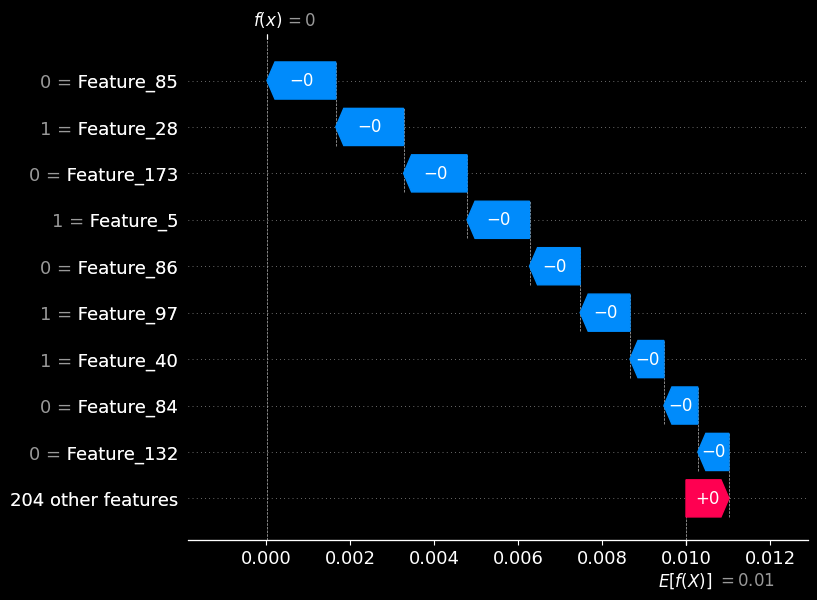

In [28]:
# Wrapper function to reshape input for the LSTM model
def lstm_predict_wrapper(data):
    # Reshape flat 2D input back to 3D (samples, timesteps, features)
    reshaped_data = data.reshape((data.shape[0], 1, data.shape[1]))  # Assuming 1 timestep
    return model.predict(reshaped_data)

# Sample a subset of the training data
X_sample = X_train[:100].reshape(100, -1)  # Flatten the 3D LSTM input to 2D
X_test_sample = X_test[:10].reshape(10, -1)  # Flatten for SHAP

# Initialize SHAP KernelExplainer with the wrapper
explainer = shap.KernelExplainer(lstm_predict_wrapper, X_sample)

# Compute SHAP values for the test subset
shap_values = explainer.shap_values(X_test_sample)

# Feature names (can generate or assign real feature names if available)
feature_names = [f"Feature_{i}" for i in range(X_sample.shape[1])]

# Select a specific instance from the test set for waterfall plot
instance_idx = 0  # Index of the test instance
instance_features = X_test_sample[instance_idx]
instance_shap_values = shap_values[0][instance_idx]

# Waterfall Plot for a Single Instance
plt.figure(figsize=(12, 8))
shap.waterfall_plot(
    shap.Explanation(
        values=instance_shap_values,
        base_values=explainer.expected_value[0],
        data=instance_features,
        feature_names=feature_names
    )
)
plt.show()

# 8. Model Evaluation

# 8.1 Confusion Matrices of All Models

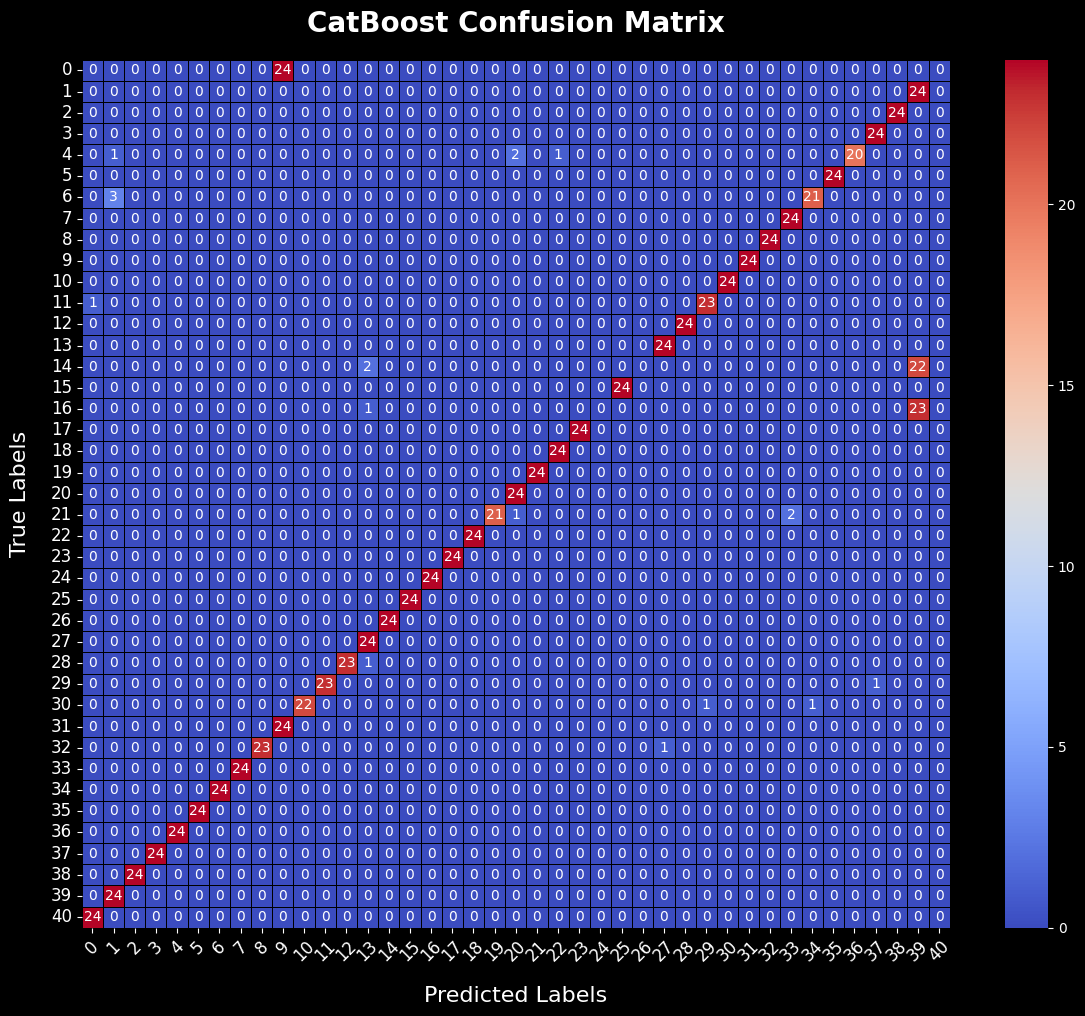

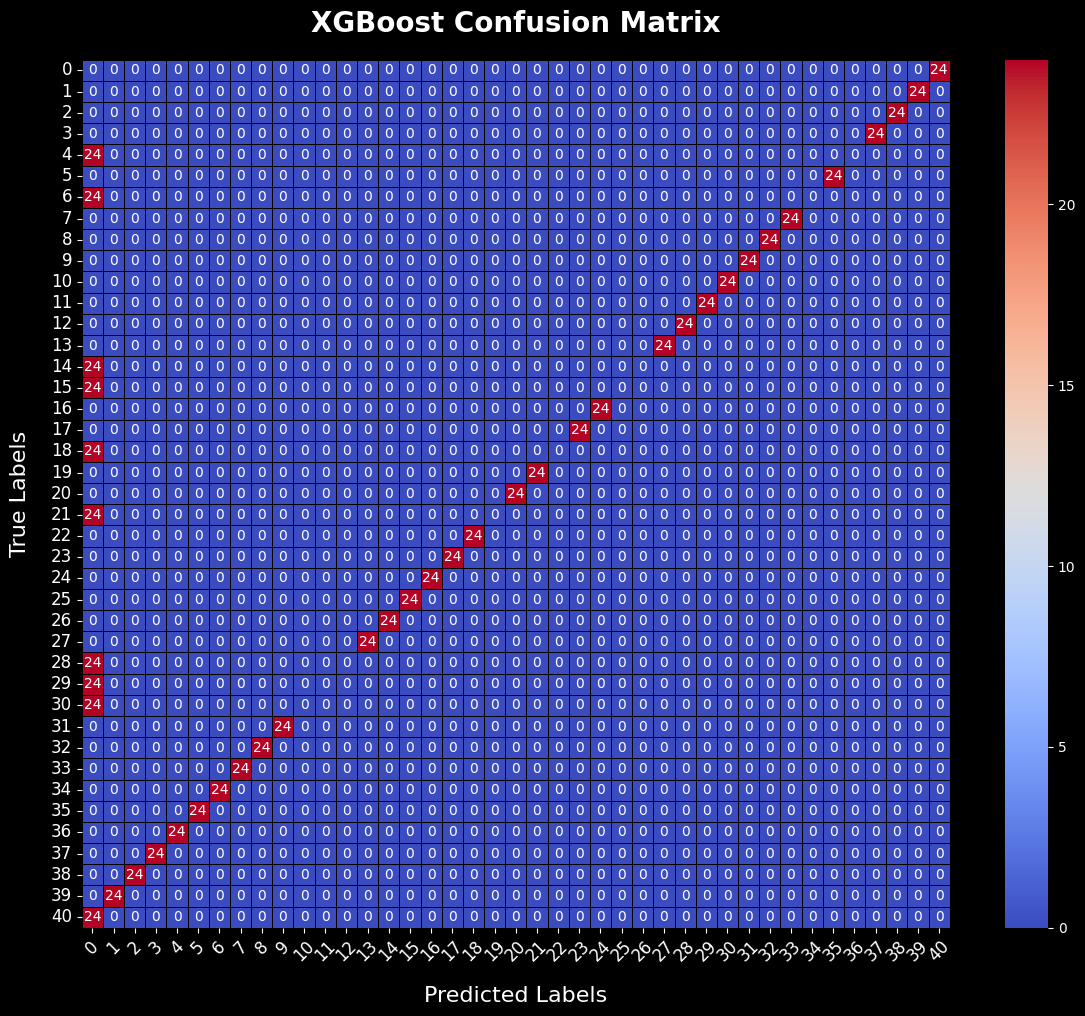

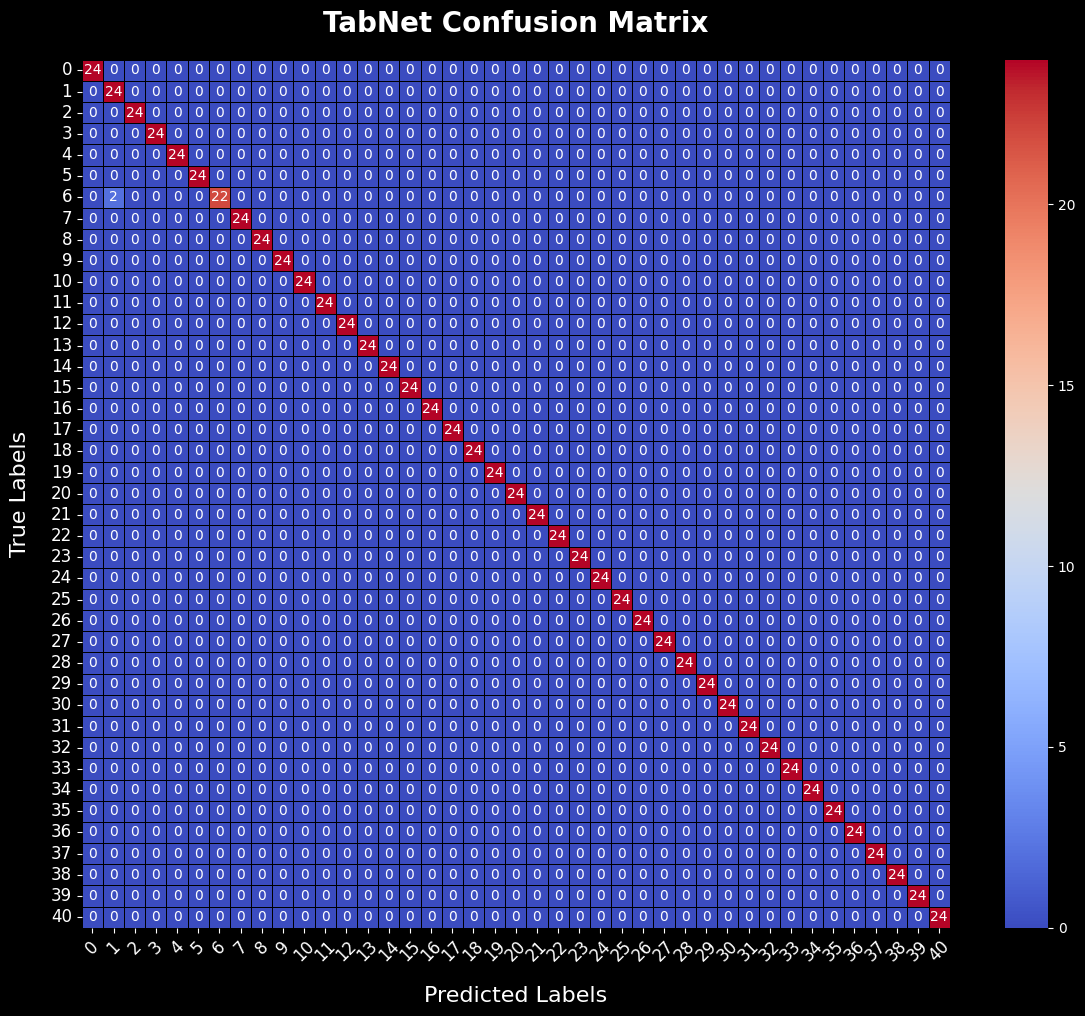

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


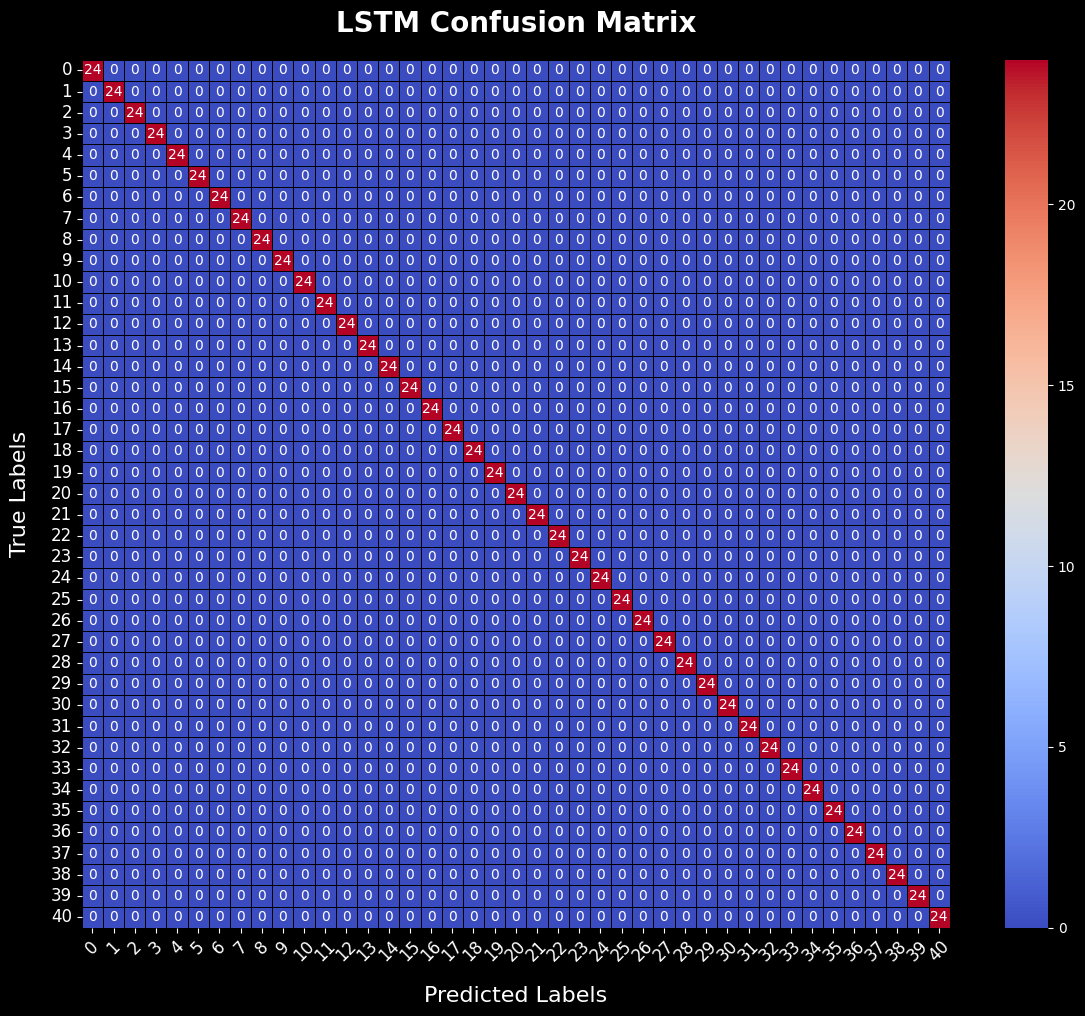

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


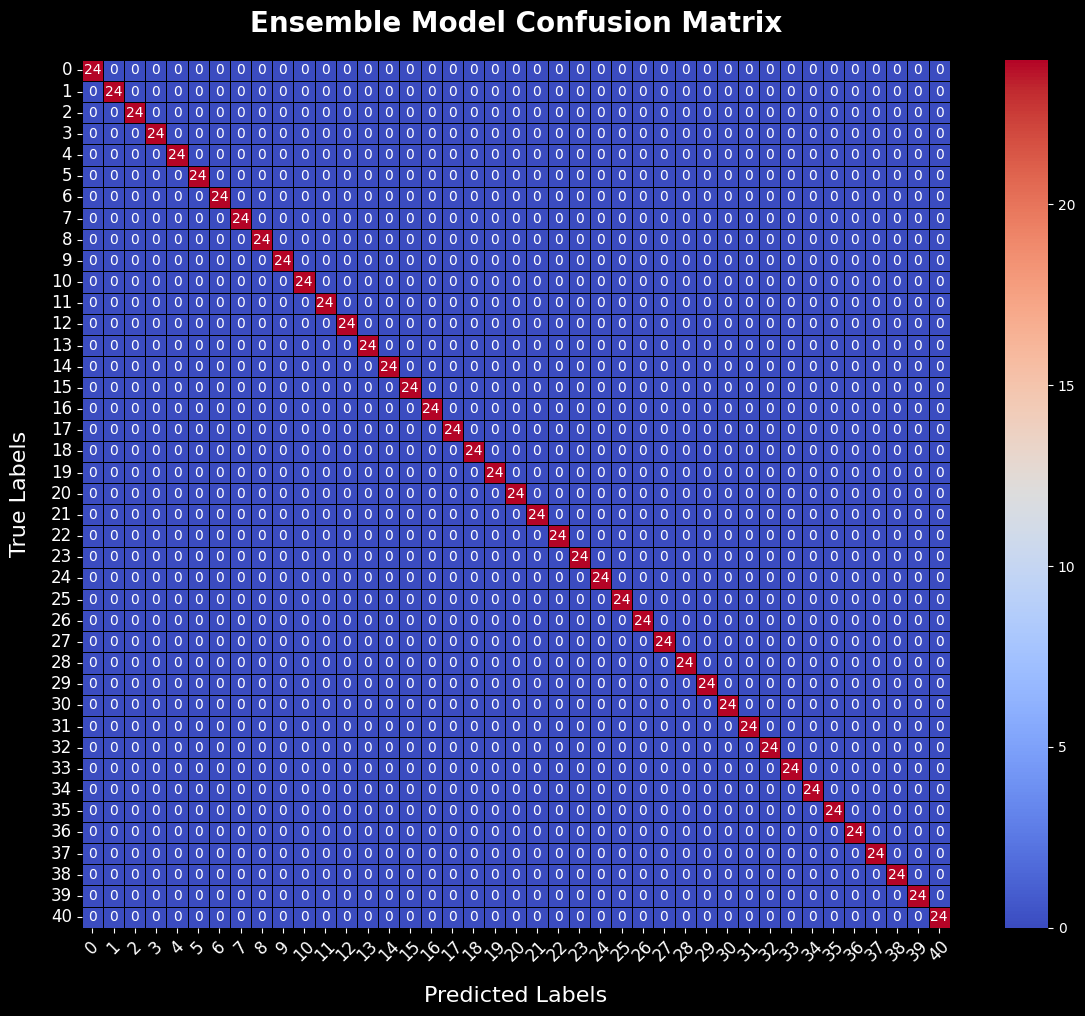

In [29]:
# Function to plot confusion matrix with stunning visuals
def plot_stunning_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='coolwarm', 
        xticklabels=labels, 
        yticklabels=labels, 
        cbar=True, 
        linewidths=0.5,
        linecolor='black',
        square=True
    )
    plt.title(title, fontsize=20, weight='bold', pad=20)
    plt.xlabel('Predicted Labels', fontsize=16, labelpad=15)
    plt.ylabel('True Labels', fontsize=16, labelpad=15)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()
    plt.show()

# Ensure X_test is 2D for CatBoost and XGBoost (remove LSTM reshaping)
X_test_2D = X_test.reshape(X_test.shape[0], -1)
X_val_2D = X_val.reshape(X_val.shape[0], -1)

# Labels for confusion matrix
labels = [str(class_name) for class_name in label_encoder.classes_]

# CatBoost Predictions and Confusion Matrix
catboost_y_pred = cat_clf.predict(X_test_2D)
plot_stunning_confusion_matrix(y_test_np, catboost_y_pred, labels, title="CatBoost Confusion Matrix")

# XGBoost Predictions and Confusion Matrix
xgb_y_pred = xgb_clf.predict(X_test_2D)
plot_stunning_confusion_matrix(y_test_np, xgb_y_pred, labels, title="XGBoost Confusion Matrix")

# TabNet Predictions and Confusion Matrix
tabnet_y_pred = tabnet_clf.predict(X_test_np)
plot_stunning_confusion_matrix(y_test_np, tabnet_y_pred, labels, title="TabNet Confusion Matrix")

# LSTM Predictions and Confusion Matrix
y_lstm_pred = model.predict(X_test)
y_lstm_pred_classes = np.argmax(y_lstm_pred, axis=1)
y_true_lstm = np.argmax(y_test, axis=1)

plot_stunning_confusion_matrix(
    y_true_lstm, y_lstm_pred_classes, labels, title="LSTM Confusion Matrix"
)

# Ensemble Model Predictions and Confusion Matrix
ensemble_y_pred = ensemble_clf.predict(X_test_2D)  # Assuming the ensemble model is built for 2D input
plot_stunning_confusion_matrix(
    y_test_1D, ensemble_y_pred, labels, title="Ensemble Model Confusion Matrix"
)

# 8.2 Model Metrics Comparison

In [30]:
# Convert targets to 1D arrays for CatBoost, XGBoost, and TabNet
y_test_1D = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

# Initialize a dictionary to store metrics
metrics_dict = {}

# Define a helper function to calculate metrics
def calculate_metrics(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")
    metrics_dict[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

# Derive Metrics for Each Model
# --- CatBoost Metrics ---
catboost_y_pred = cat_clf.predict(X_test_2D)
calculate_metrics("CatBoost", y_test_1D, catboost_y_pred)

# --- XGBoost Metrics ---
xgb_y_pred = xgb_clf.predict(X_test_2D)
calculate_metrics("XGBoost", y_test_1D, xgb_y_pred)

# --- TabNet Metrics ---
tabnet_y_pred = tabnet_clf.predict(X_test_np)
calculate_metrics("TabNet", y_test_np, tabnet_y_pred)

# --- LSTM Metrics ---
y_lstm_pred = model.predict(X_test)
y_lstm_pred_classes = np.argmax(y_lstm_pred, axis=1)
y_true_lstm = np.argmax(y_test, axis=1)
calculate_metrics("LSTM", y_true_lstm, y_lstm_pred_classes)

# --- Ensemble Model Metrics ---
ensemble_y_pred = ensemble_clf.predict(X_test_2D)  # Assuming the ensemble model works with 2D input
calculate_metrics("Ensemble Model", y_test_1D, ensemble_y_pred)

# Convert metrics dictionary to DataFrame
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient="index")

# Display the updated metrics table
print("\Comparison of Model Metrics:")
print(metrics_df)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
\Comparison of Model Metrics:
                Accuracy  Precision    Recall  F1 Score
CatBoost        0.910569   0.881145  0.910569  0.889146
XGBoost         0.780488   0.758537  0.780488  0.760532
TabNet          0.997967   0.998124  0.997967  0.997964
LSTM            1.000000   1.000000  1.000000  1.000000
Ensemble Model  1.000000   1.000000  1.000000  1.000000


# 8.3 Plot for Metrics Comparison

<Figure size 1200x800 with 0 Axes>

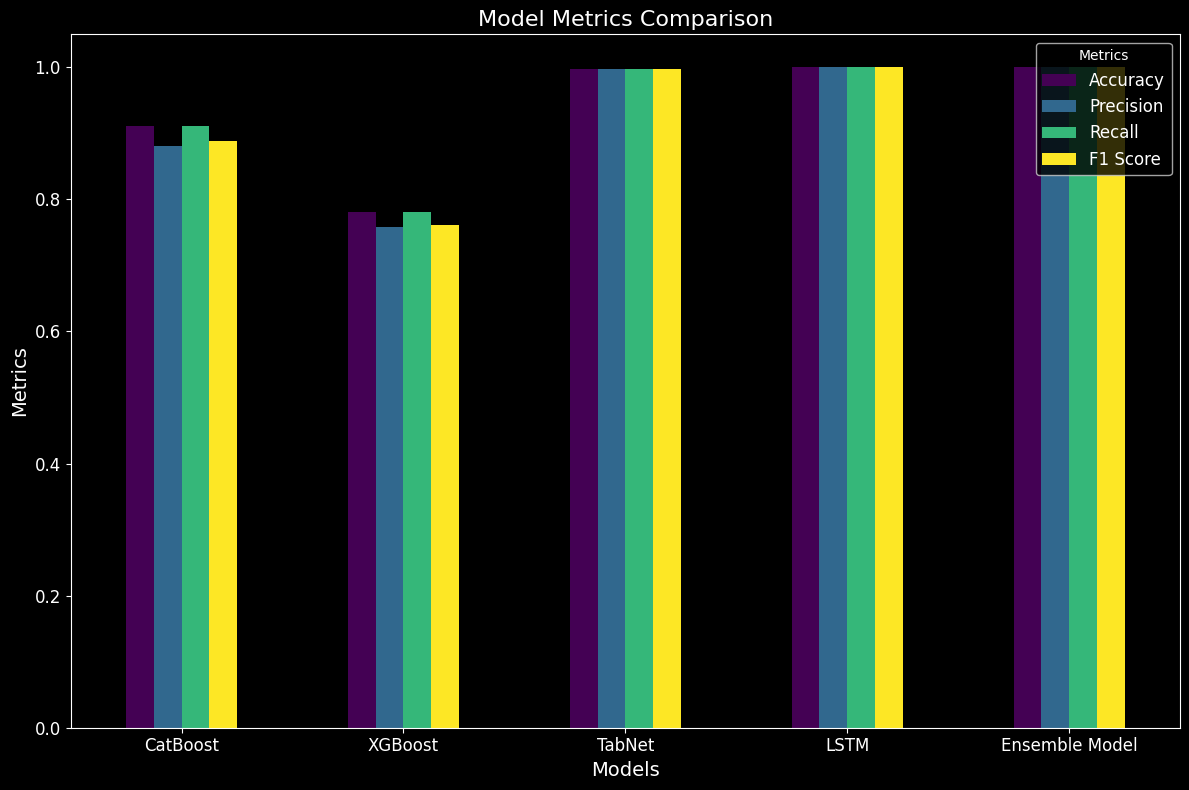

In [31]:
# Convert metrics dictionary to DataFrame
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient="index")

# Plot Accuracy, Precision, Recall, and F1 Score for all models
plt.figure(figsize=(12, 8))
metrics_df.plot(kind='bar', figsize=(12, 8), colormap='viridis', rot=0)
plt.title("Model Metrics Comparison", fontsize=16)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Metrics", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=12, title='Metrics')
plt.tight_layout()
plt.show()

# 8.4 ROC-AUC Curves

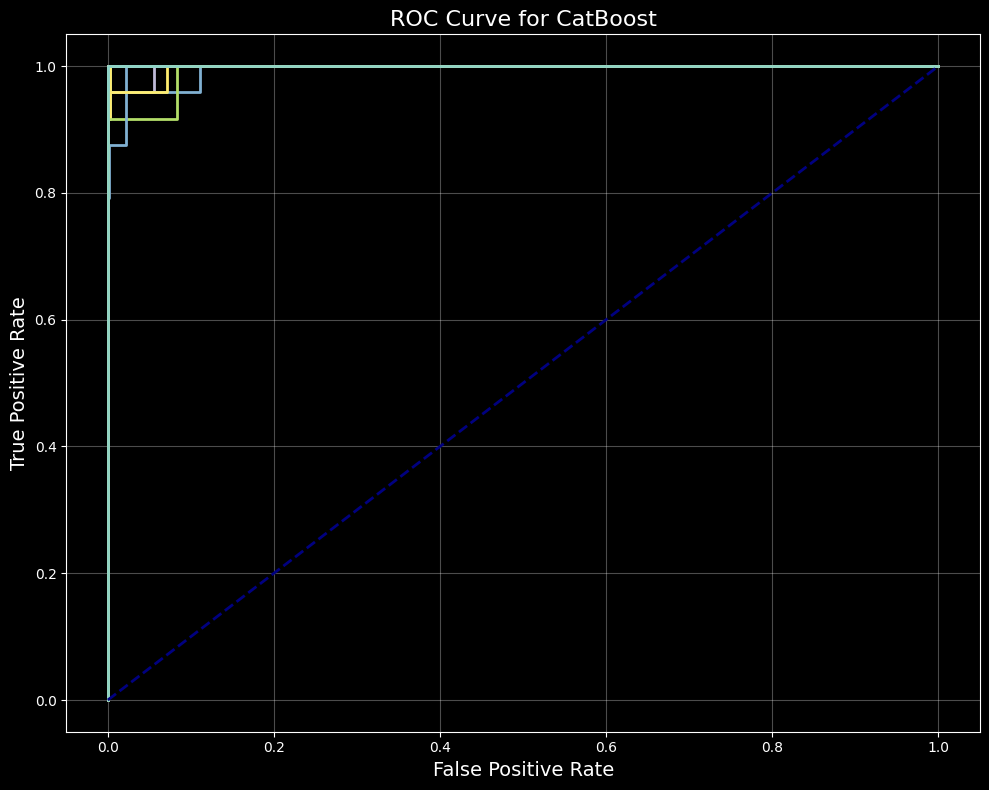

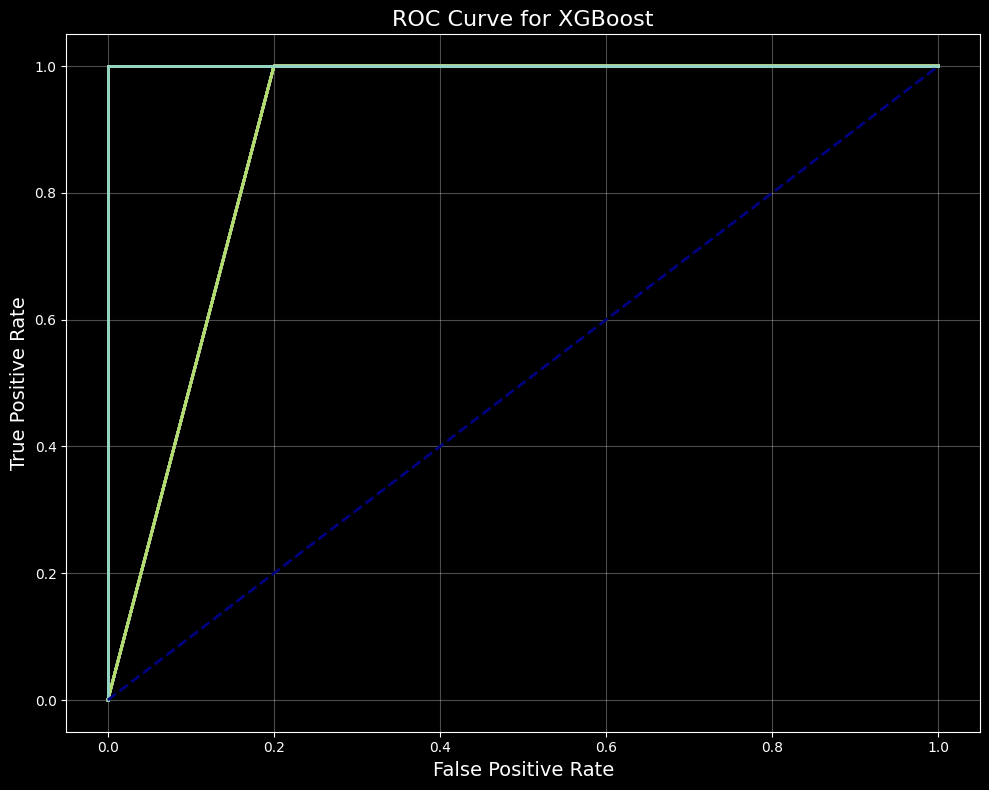

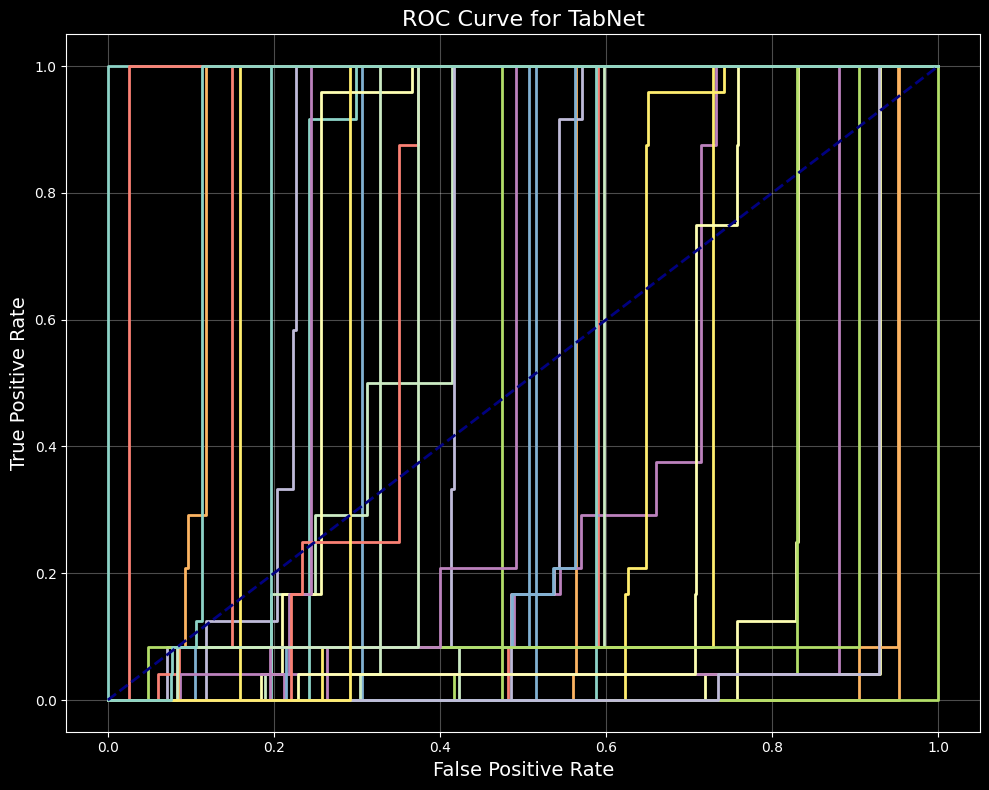

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


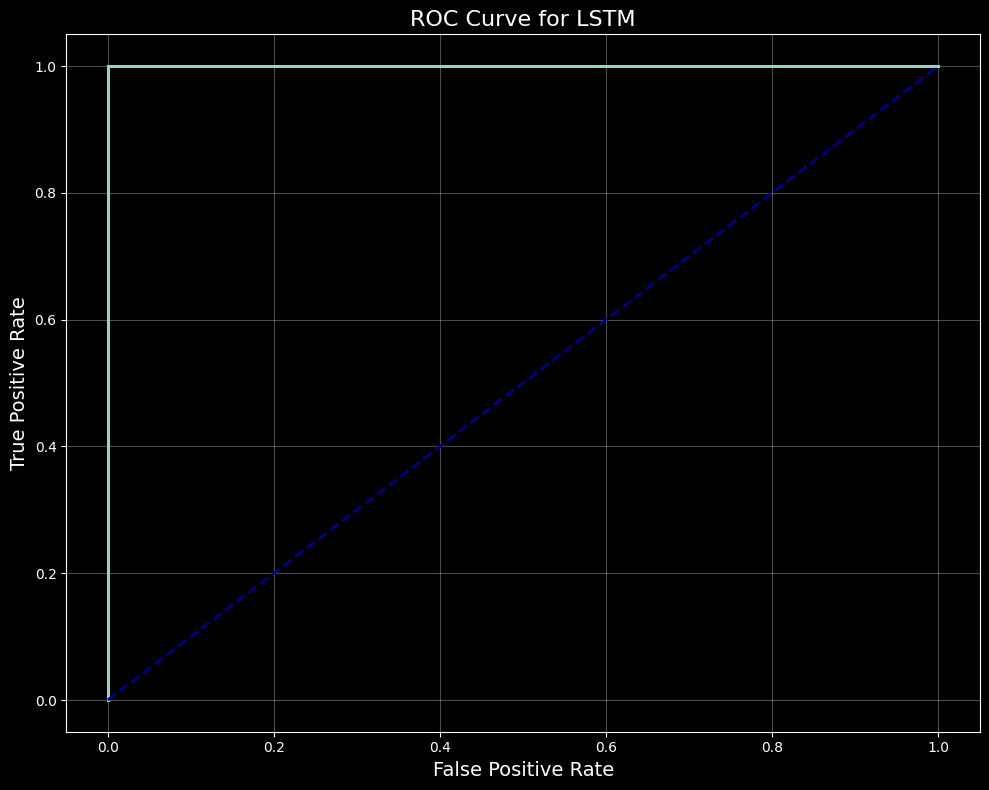

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


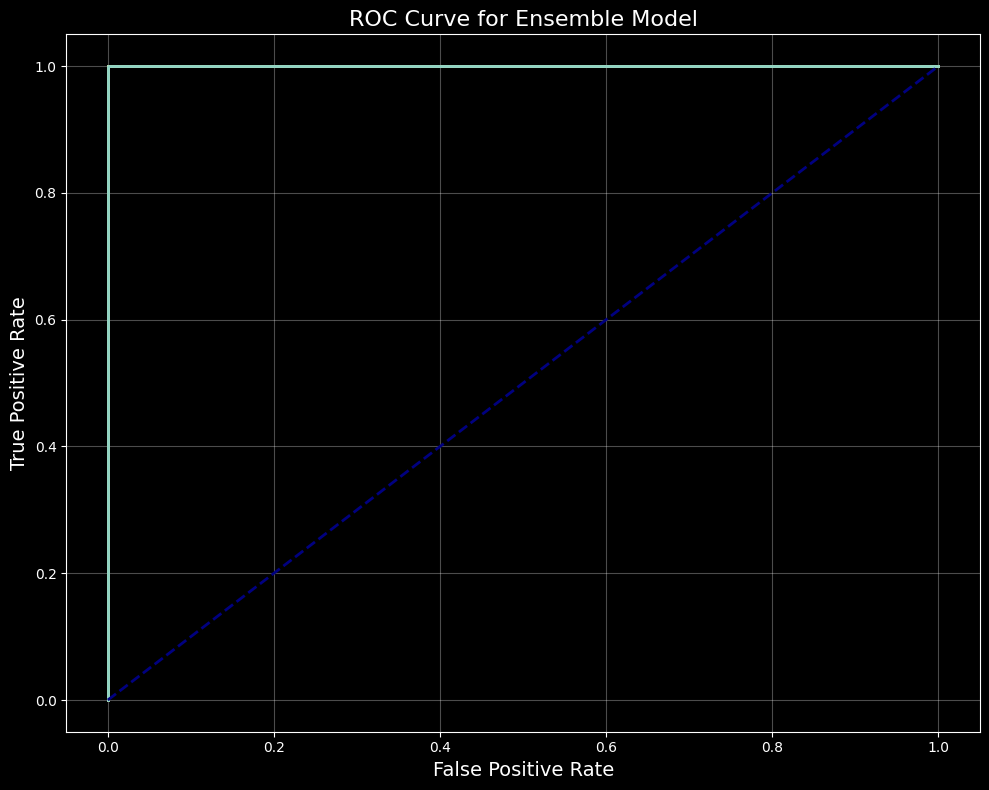

In [32]:
# Ensure the target variable is binary or one-hot encoded for ROC computation
n_classes = y_test.shape[1]

# One-vs-Rest ROC plotting
def plot_roc_curve_no_legend(y_true, y_proba, model_name, n_classes):
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2)

    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.title(f"ROC Curve for {model_name}", fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- CatBoost ROC ---
catboost_y_proba = cat_clf.predict_proba(X_test_2D)
plot_roc_curve_no_legend(y_test, catboost_y_proba, "CatBoost", n_classes)

# --- XGBoost ROC ---
xgb_y_proba = xgb_clf.predict_proba(X_test_2D)
plot_roc_curve_no_legend(y_test, xgb_y_proba, "XGBoost", n_classes)

# --- TabNet ROC ---
tabnet_y_proba = tabnet_clf.predict_proba(X_test_np)
plot_roc_curve_no_legend(y_test, tabnet_y_proba, "TabNet", n_classes)

# --- LSTM ROC ---
y_lstm_proba = model.predict(X_test)
plot_roc_curve_no_legend(y_test, y_lstm_proba, "LSTM", n_classes)

# --- Ensemble Model ROC ---
ensemble_y_proba = ensemble_clf.predict_proba(X_test_2D)  # Assuming ensemble works with 2D input
plot_roc_curve_no_legend(y_test, ensemble_y_proba, "Ensemble Model", n_classes)

# 9. Save the Best Model 

Best model is 'Ensemble Model' and it has been saved as 'best_model_ensemble.pkl'
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


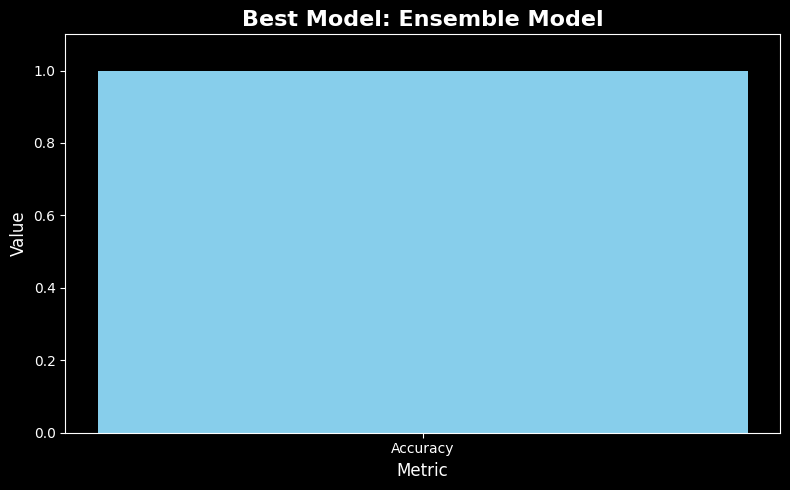

Best model is 'Ensemble Model' with a Test Accuracy of 1.0000, saved as 'best_model_ensemble.pkl'


In [33]:
import joblib  # Use joblib for saving ensemble models

# Save the best-performing model (Ensemble Model in this case)
best_model_name = "Ensemble Model"
best_model_file = "best_model_ensemble.pkl"
joblib.dump(ensemble_clf, best_model_file)  # Save the ensemble model using joblib
print(f"Best model is '{best_model_name}' and it has been saved as '{best_model_file}'")

# Load the saved model to verify
loaded_model = joblib.load(best_model_file)

# Evaluate the loaded model on the test set
ensemble_y_pred = loaded_model.predict(X_test_2D)
test_accuracy = accuracy_score(y_test_1D, ensemble_y_pred)

# Visualize the best model details
plt.figure(figsize=(8, 5))
plt.bar(["Accuracy"], [test_accuracy], color="skyblue")
plt.ylim(0, 1.1)
plt.title(f"Best Model: {best_model_name}", fontsize=16, weight="bold")
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.text(0, test_accuracy + 0.05, f"{test_accuracy:.4f}", ha="center", fontsize=12, color="black")
plt.tight_layout()
plt.show()

print(f"Best model is '{best_model_name}' with a Test Accuracy of {test_accuracy:.4f}, saved as '{best_model_file}'")